## Goal of the Challenge
---

We will be using a neural network model.
**Briefly summarise the goal of the challenge of your choice and provide an abstract of your analysis.**


In [1]:
%matplotlib inline

from reader import get_housing_data
import pandas as pd
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import random

In [2]:
#Getting the data
data = get_housing_data()
data.head()

,Order,PID,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [3]:
#First drop the columns that are obviously not correlated
data.columns

Index(['Order', 'PID', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemod/Add', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 

In [4]:
data = data.drop(['PID','Order'], axis=1)

There are continuous, but also categorical features, so I'll use dummy variables for the nominal variables.
<br>I'll also encode ordinal features that have NA such as bsmtcond in one-hot, since NA has to be a separate category.

In [5]:
nominal_columns=['MSSubClass', 'MSZoning','Street','Alley', 'LandContour', 'LotConfig',
    'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle','RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'Foundation','Heating','CentralAir','GarageType','SaleType',
       'SaleCondition','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
                'Electrical','FireplaceQu','GarageFinish','GarageQual','GarageCond',
                'PoolQC','Fence','MiscFeature']

In [6]:
data = pd.get_dummies(data, prefix=nominal_columns, columns=nominal_columns)

We then encode the ordinal features (one by one). <br>This is needed before checking for any correlations to sale price if we don't want to be making any assumptions.

In [7]:
cleanup_nums = {"LotShape":     {"Reg": 1, "IR1": 2, "IR2":3, "IR3":4},
                "Utilities": {"AllPub": 3, "NoSewr": 2, "NoSeWa": 1, "ELO": 0},
                "LandSlope": {"Gtl": 1, "Mod": 2, "Sev": 3},
                "ExterQual": {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
                "ExterCond": {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
                "HeatingQC": {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
                "KitchenQual": {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1},
                "Functional" : {'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,'Min1':6,'Typ':7},
                "PavedDrive" : {'Y':3,'P':2,'N':1}}

data.replace(cleanup_nums, inplace=True)
data = data.astype('float64')

For feature selection, we use pearson's correlation metric and choose +-.2 threshold.
<br>There are too many features for a scatter matrix visualisation.<br>I try to keep as much information as possible, this can be adjusted later to train faster e.g.

In [8]:
corr = data.corrwith(data.SalePrice).sort_values()
threshold = .5
corr.head()

BsmtQual_TA         -0.452487
GarageFinish_Unf    -0.421876
MasVnrType_None     -0.403962
GarageType_Detchd   -0.365074
Foundation_CBlock   -0.349642
dtype: float64

In [9]:
features = corr.index[abs(corr)>threshold].tolist()
features.remove('SalePrice')

We can still visualize a general correlation matrix for the variables most correlated to price

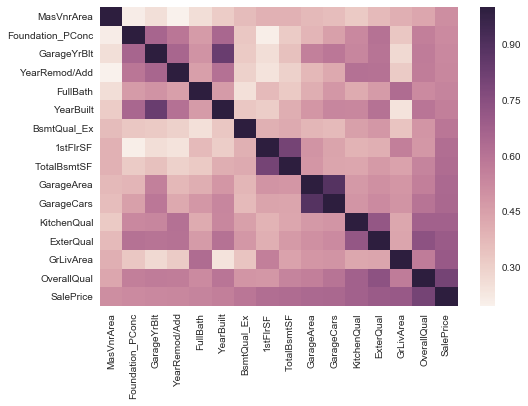

In [10]:
corr = data[corr.index[abs(corr)>0.5].tolist()].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

The dataset has nan values which cannot be used in the nn. We try to impute average value, since about 700/2900 rows have nan.

In [11]:
data = data.fillna(data.mean()).sort_index()

#normalise data
x = data[features].values #returns a numpy array
scaler = preprocessing.RobustScaler()
x_scaled = scaler.fit_transform(x)
data[features] = pd.DataFrame(x_scaled, columns=features)

#Split the data in train-dev-test
train, dev, test = np.split(data.sample(frac=1), [int(.6*len(data)), int(.8*len(data))])
train_X = train[features]
train_Y = train['SalePrice']
dev_X = dev[features]
dev_Y = dev['SalePrice'].reshape(dev.shape[0],1)
test_X = test[features]
test_Y = test['SalePrice'].reshape(test.shape[0],1)

/Users/aimihat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/Users/aimihat/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()


After experimention, settling on the following hyperparameters:

In [12]:
run_name = 'final2.5'
#Network parameters
n_hidden_1 = 40
n_hidden_2 = 20
n_hidden_3 = 10
num_input = len(features)

In [13]:
#Setting the hyperparameters
learning_rate = 0.001
n_epochs = 12000
display_step = 1000
batch_size = train_X.shape[0]
remain_prob = 0.999

In [14]:
#Tf Graph input
with tf.name_scope('input'):
    X = tf.placeholder("float", [None,num_input], name='X_input')
    Y = tf.placeholder("float", [None,1], name='Y_input')

with tf.name_scope('weights'):
    weights = {
        'W1': tf.get_variable('W1', [num_input, n_hidden_1],initializer=tf.contrib.layers.xavier_initializer()),
        'W2': tf.get_variable('W2',[n_hidden_1, n_hidden_2],initializer=tf.contrib.layers.xavier_initializer()),
        'W3': tf.get_variable('W3',[n_hidden_2, n_hidden_3],initializer=tf.contrib.layers.xavier_initializer()),
        'W_out': tf.get_variable('W_out',[n_hidden_3, 1])
    }
with tf.name_scope('biases'):
    biases = {
        'b1': tf.get_variable('b1',[n_hidden_1]),
        'b2': tf.get_variable('b2',[n_hidden_2]),
        'b3': tf.get_variable('b3',[n_hidden_3]),
        'b_out': tf.get_variable('b_out',[1])
    }

In [ ]:
### Create model
def neural_net(x):
    layer_1 = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(x, weights['W1']), biases['b1'])),remain_prob)
    layer_2 = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(layer_1, weights['W2']), biases['b2'])),remain_prob)
    layer_3 = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(layer_2, weights['W3']), biases['b3'])),remain_prob)
    out_layer = tf.matmul(layer_3, weights['W_out']) + biases['b_out']
    return out_layer

logits = neural_net(X)
with tf.name_scope('prediction'):
    prediction = logits

In [ ]:
with tf.name_scope('Loss'):
    loss_op = tf.reduce_mean(tf.losses.absolute_difference(labels=Y,predictions=logits))
    mean_square_error = tf.reduce_mean(tf.squared_difference(logits, Y))
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op)

init = tf.global_variables_initializer()

tf.summary.scalar("cost", loss_op)
tf.summary.scalar("mean_square", mean_square_error)

summary_op = tf.summary.merge_all()

*Figure: Tensor graph used*
![Tensor graph used](files/graph.png)

In [ ]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert inputs.shape[0] == targets.shape[0]
    if shuffle:
        indices = np.arange(inputs.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
        

saver = tf.train.Saver()

# Start training
with tf.Session() as sess:

    # Run the initializer
    file_writer = tf.summary.FileWriter('/tmp/tensorlogs/'+run_name, sess.graph)
    curves_writer = tf.summary.FileWriter('/tmp/tensorlogs/'+run_name+'curves', sess.graph)
    sess.run(init)
    step = 0
    for epoch in range(n_epochs):
        assert not np.any(np.isnan(train_X))
        for batch in iterate_minibatches(train_X, train_Y, batch_size):
            batch_x, batch_y = batch
            batch_y = batch_y.values.reshape(batch_size,1)
            step += 1
            
            # Run optimization op (backprop)
            _,loss_summary = sess.run([train_op, summary_op], feed_dict={X: batch_x, Y: batch_y})
            curves_summary = sess.run(summary_op, feed_dict={X: dev_X, Y: dev_Y})
            file_writer.add_summary(loss_summary, epoch * batch_size + step)
            curves_writer.add_summary(curves_summary, epoch * batch_size + step)
            
            if epoch % display_step == 0:
                # Calculate batch loss and accuracy
                tf.add_to_collection("prediction", prediction)
                loss = sess.run(loss_op, feed_dict={X: batch_x,Y: batch_y})
                saver.save(sess, "/tmp/model.ckpt", global_step=epoch, write_meta_graph=False)
                print("Epoch " + str(epoch) + ", Minibatch Loss= " + \
                      "{:.4f}".format(loss))


In [ ]:
#To make predictions after training, here it does a random row prediction
row = random.randrange(train_Y.shape[0])
with tf.Session() as sess:
  # Restore variables from disk.
    #new_saver = tf.train.import_meta_graph('/tmp/model.ckpt-40000.meta')
    saver.restore(sess, tf.train.latest_checkpoint('/tmp/'))
    print("Model restored.")
    # Check the values of the variables
    print('actual: ',train_Y.iloc[row])
    print('prediction: ',sess.run(prediction, feed_dict={X:train_X.iloc[row].reshape(1,len(features))}))
    
    print('test error:', sess.run([loss_op,mean_square_error], feed_dict={X:test_X,Y:test_Y}))

We can then compare our model to a simple linear regression